In [1]:
# 可视化卷积神经网络过滤器
# 为过滤器的可视化定义损失张量
from keras.applications import VGG16
from keras import backend as k

model = VGG16(
    weights='imagenet',
    include_top = False
)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = k.mean(layer_output[:, :, :, filter_index])



Using TensorFlow backend.



In [2]:
# 获取损失相对于输入的梯度
grads = k.gradients(loss, model.input)[0]



In [3]:
# 梯度标准化技巧
grads /= (k.sqrt(k.mean(k.square(grads)))) + 1e-5



In [4]:
# 给定numpy输入值，得到numpy输出值
iterate = k.function([model.input], [loss, grads])

import numpy as np

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])



In [5]:
# 通过随机梯度下降让损失最大化
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
step = 1. # 梯度更新步长
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])

    input_img_data += grads_value * step



In [6]:
# 将张量转换为有效图像的实用函数
def depreocess_image(x):
    x -=x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x 



In [7]:
# 生成过滤器可视化的函数
def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = k.mean(layer_output[:,:,:, filter_index])

    grads = k.gradients(loss, model.input)[0]

    grads /= (k.sqrt(k.mean(k.square(grads))) + 1e-5)

    iterate = k.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return depreocess_image(img)



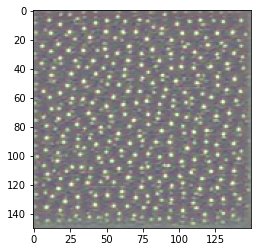

In [8]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern('block3_conv1', 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


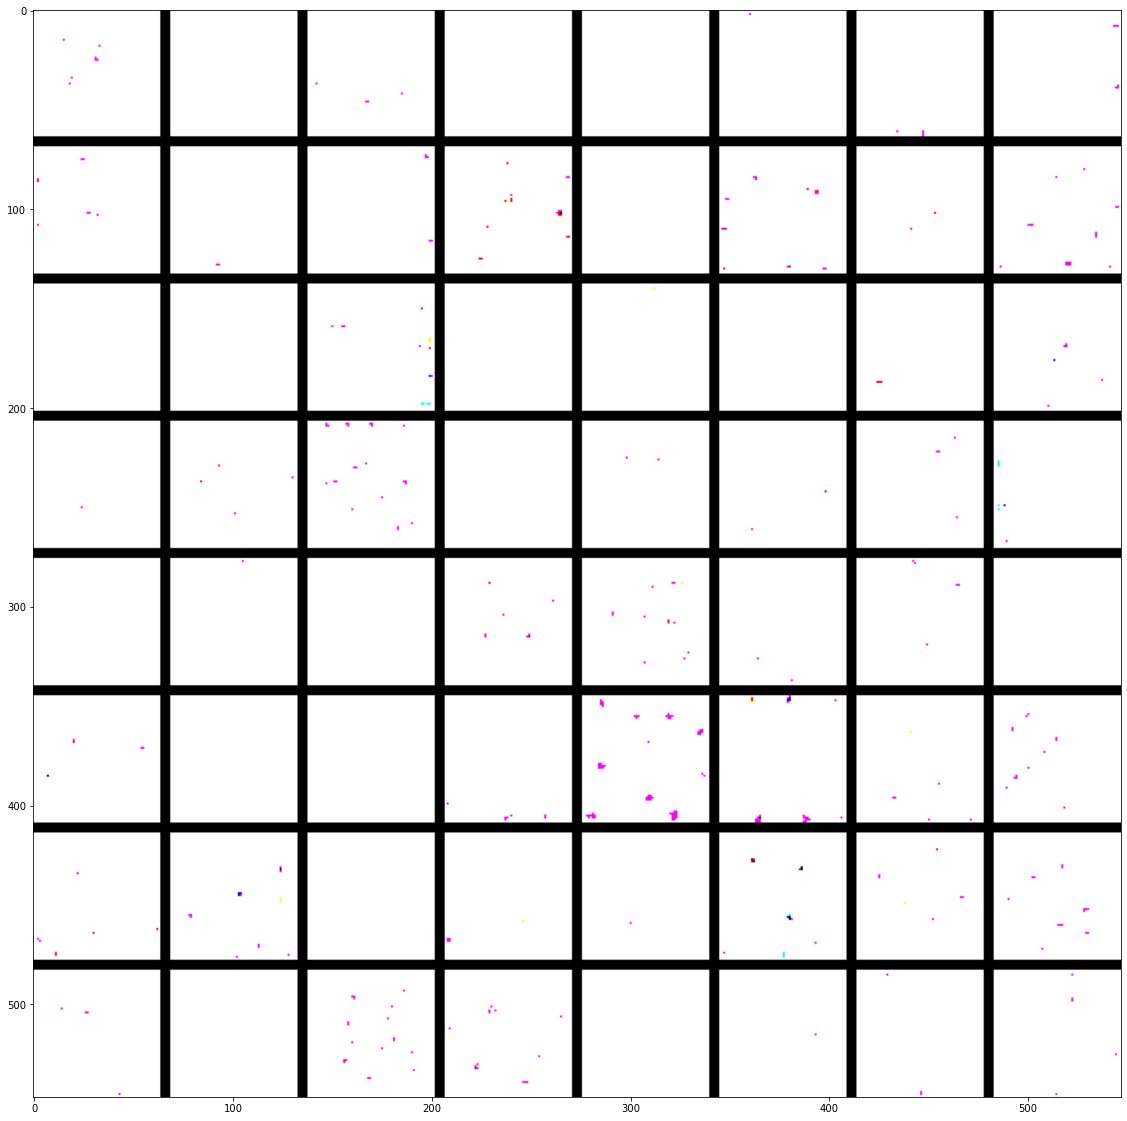

In [9]:
# 生成某一层中所有过滤器相应模式组成的网格
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8): # 行
    for j in range(8): # 列
        filter_img = generate_pattern(layer_name, i + (j * 8), size = size)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size 
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size 
        results[horizontal_start : horizontal_end,
                vertical_start : vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)
